In [50]:
# CAGE spectrum check
# 13 Oct 2022

# code sources -- CAGE/analysis/nplus.ipynb
#              -- CAGE/processing/energy_raw.ipynb

# "392":["2562-2565", "alp", "elog 437. oppi wellness checks, skip 2562"],

# "414":["2755-2783", "alp", "elog 443. Rebiasing icpc after attempted collimator fix.  HV lower at 3500 V."],
# "415":["2784-2813", "alp", "elog 443.  may show settling of detector & improved resolution"],
# "416":["2814-2855", "alp", "elog 443.  after preamp tuning and turning off motor controller noise."],
# "417":["2856-2863", "alp", "elog 443  morning alpha runs"]

In [51]:
import os, sys, h5py, json, time
import pandas as pd
import numpy as np
import h5py
from scipy.optimize import curve_fit
from scipy.ndimage.filters import gaussian_filter

# use this to get interactive plots at NERSC.  
# requires ipympl & jupyter-matplotlib extension for jupyterlab
# user may need to $pip install ipympl --update
%matplotlib widget
# Successfully installed ipympl-0.9.2

import matplotlib.pyplot as plt

import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    from tqdm import tqdm
    tqdm.pandas() # suppress annoying FutureWarning

In [52]:
# from pygama import DataGroup, lh5

# imports for pygama tag v1.1.0, oct 2022.
from pygama.flow import DataGroup
import pygama.lgdo.lh5_store as lh5
import pygama.math.histogram as pgh
    
# import pygama.analysis.histograms as pgh
# import pygama.analysis.peak_fitting as pgf

# from pygama.dsp.dsp_optimize import *
# from pygama.dsp.WaveformBrowser import WaveformBrowser as wfb
# from pygama.io.hit_to_evt import cluster_events

In [45]:
dg = DataGroup('../processing/cage.json', load=True)    
    
# que = 'run >= 414 and run <= 417' 
# que = 'run == 416' # icpc in cage
que = 'cycle >=2563 and cycle <= 2565' # oppi in cage recently

df_cycles = dg.fileDB.query(que)

# # df_runs.columns
# # ['unique_key', 'YYYY', 'mm', 'dd', 'cycle', 'daq_dir', 'daq_file', 'run',
# #        'runtype', 'detector', 'skip', 'dsp_id', 'raw_file', 'raw_path',
# #        'dsp_file', 'dsp_path', 'hit_file', 'hit_path', 'startTime',
# #        'threshold', 'daq_gb', 'stopTime', 'runtime']

view = ['run','cycle','daq_file','startTime','threshold','daq_gb','runtime']
df_cycles[view]

,run,cycle,daq_file,startTime,threshold,daq_gb,runtime
2554,392,2563,2022-9-12-CAGERun2563,1.663024e+09,32.0,0.069027,1.185056
2555,392,2564,2022-9-12-CAGERun2564,1.663025e+09,48.0,1.110110,19.999281
2556,392,2565,2022-9-12-CAGERun2565,1.663026e+09,48.0,1.062588,19.341065


In [46]:
# check the first raw file and show the available LH5 tables and column names
raw_files = dg.lh5_dir + df_cycles['raw_path'] + '/' + df_cycles['raw_file']

# h5py has a funny way of iterating through groups, you have to pass 'visititems' a function
def print_attrs(name, obj):
    for key, val in obj.attrs.items():
        if 'table' in val: # debug, only show tables.
            print(name)
            print("    %s: %s" % (key, val))

print('Raw file 0:')
with h5py.File(raw_files.iloc[0]) as hf:
    print(raw_files.iloc[0])
    hf.visititems(print_attrs)

Raw file 0:
/global/cfs/cdirs/m2676/data/cage/LH5/raw/cage_run392_cyc2563_raw.lh5
ORSIS3302DecoderForEnergy/raw
    datatype: table{packet_id,energy,energy_first,timestamp,crate,card,channel,waveform}
ORSIS3302DecoderForEnergy/raw/waveform
    datatype: table{t0,dt,values}


In [47]:
# load enough data to make an energy spectrum in both channels, and save some other interesting variables too

def load_events(row, tb_name, data_cols, tb_type):
    """
    I should add this function to DataGroup in pygama, it's like GATDataSet:GetGatifiedChain
    """
    # print(row)
    lh5_file = dg.lh5_dir + row[f'{tb_type}_path'] + '/' + row[f'{tb_type}_file']
    lh5_data = pd.DataFrame(lh5.load_nda(lh5_file, data_cols, tb_name))
    lh5_data['cycle'] = row['cycle']
    return lh5_data

# data_cols = ['channel','timestamp','energy','trapEmax','trapEftp','bl','bl_sig','bl_slope','bl_intercept',
#              'wf_max','wf_argmax','tp_0','dcr','A_10','triE','hf_max','lf_max','tp_max']

data_cols = ['energy','energy_first', 'timestamp']

ncycles = 10
tb_type = 'raw'
etype = 'energy'

# tmp = df_cycles[:ncycles].progress_apply(load_events, axis=1, args=('ORSIS3302DecoderForEnergy/raw', data_cols, tb_type,))

tmp = df_cycles.progress_apply(load_events, axis=1, args=('ORSIS3302DecoderForEnergy/raw', data_cols, tb_type,))

df_hits = pd.concat([df for df in tmp])
print('In-memory size:', round(sys.getsizeof(df_hits) / 1024 / 1024, 2), "MB")

# df_hits['energy'].max()
df_hits



100%|██████████| 3/3 [00:03<00:00,  1.18s/it]

In-memory size: 4.16 MB


,energy,energy_first,timestamp,cycle
0,95082,1586,5256704,2563
1,252966,4294965654,9803415,2563
2,268356,4294966761,14030111,2563
3,142970,1922,19925322,2563
4,123871,4294965632,20073077,2563
...,...,...,...,...
64660,2187624,4294965772,116038133287,2565
64661,117930,4294966901,116041451145,2565
64662,73218,4294965977,116042225419,2565
64663,75363,676,116043448836,2565


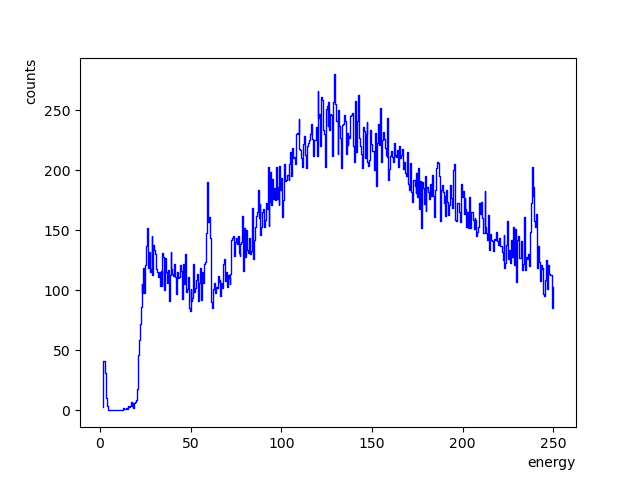

In [49]:
%matplotlib widget


# histogram energy data for this estimator -- TODO: and normalize by runtime

# uncalibrated plot
xlo, xhi, xpb = 0, 4e6, 10000   # good for energy
data = df_hits[etype]
hist, bins, var = pgh.get_hist(data, range=(xlo, xhi), dx=xpb)

# # rough calibrated plot.
# elo, ehi, epb = 1, 250, 0.5 # 1--250 keV range
# run 414, one point calibration - 1460 keV = 1.954e6 in `energy`.
# cal = 1460 / 1.954e6
# cal = 1460 / 1.928e6
cal = 1460 / 1.830e6 # oppi in cage sep 2022
data_cal = df_hits[etype] * cal
hist, bins, var = pgh.get_hist(data_cal, range=(elo, ehi), dx=epb)

bins = bins[1:] # trim zero bin, not needed with ds='steps'

# hist_rt = np.divide(hist, runtime_min * 60)
# print(f'\nRaw E: {etype}, {len(data)} cts, runtime: {runtime_min:.2f} min')

# plt.semilogy(bins, hist, ds='steps', c='b', lw=1, label=etype)
plt.plot(bins, hist, ds='steps', c='b', lw=1, label=etype)

plt.xlabel(etype, ha='right', x=1)
# plt.ylabel(f'cts/sec, {xpb}/bin', ha='right', y=1)
plt.ylabel('counts', ha='right', y=1)
plt.show()
